In [ ]:
#!df -h
#!cat /proc/cpuinfo
#!cat /proc/meminfo.


DPI = 300

#Valori in cm
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

#impostazione della dimesione dei font
#plt.rcParams.update({'font.size': 8})

#np.random.seed(10)

#import e gloabals e funzioni
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator, PCG64
%matplotlib inline

In [ ]:
#Scarichiamo il dataset Mnist attraverso il modulo di sklearn
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202)
k = 10

kmeans = KMeans(init="random", n_clusters=k, n_init=20,
                random_state=2021, n_jobs = -1)
model = kmeans.fit(X_train)
#inertia
print(model.inertia_)
#silhouette
s = metrics.silhouette_score(X_train, model.labels_,
                             metric="euclidean", sample_size=1000,)
print(s)

924689.0438455659
0.18310943705916088


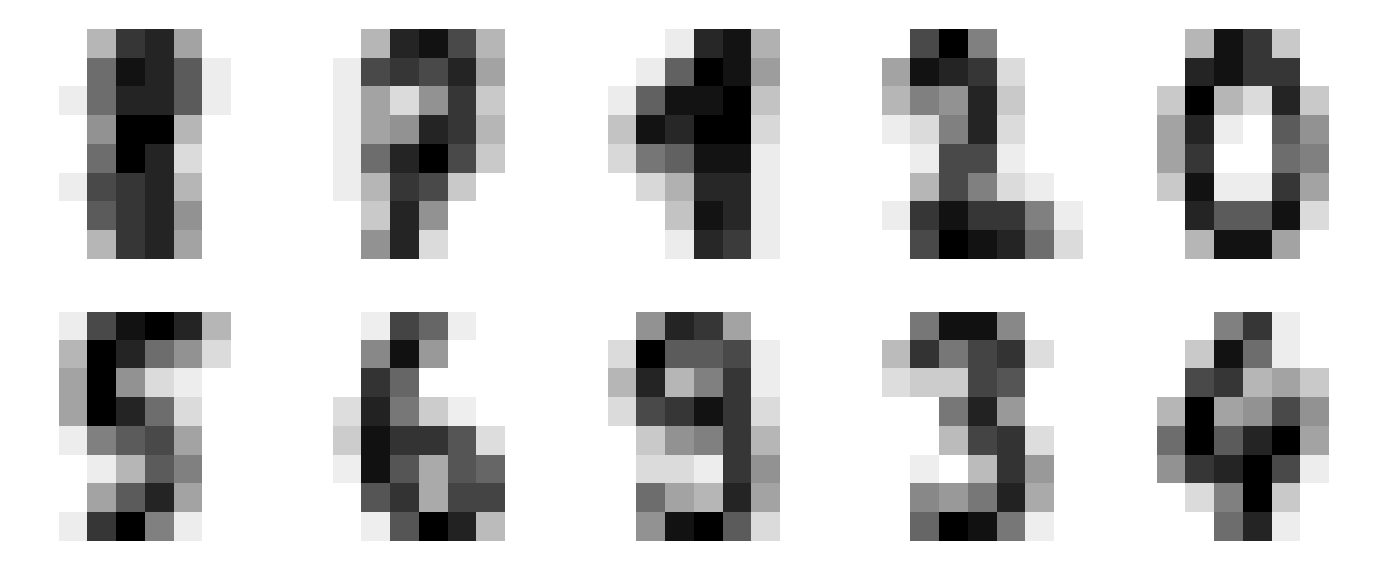

In [ ]:
# record centroid values
centroids = model.cluster_centers_

# reshape centroids into images
images = centroids.reshape(k, 8, 8)
#images *= 255
images = images.astype(np.uint8)

# create figure with subplots using matplotlib.pyplot
fs=(cm2inch(12,6))
fig, axs = plt.subplots(int(k/5), 5, figsize = fs, tight_layout = True, dpi = DPI)
plt.gray()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.tight_layout()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):    
    # add image to subplot    
    ax.matshow(255-images[i])
    ax.axis('off')

# display the figure
fig.show()
fig.savefig('6.2.png')



In [ ]:
from sklearn.metrics import accuracy_score

kmeans_labels = [8, 7, 1, 2, 0, 5, 6, 9, 3, 4] #Si devono cambiare ogni volta
preds = model.predict(X_test)
label_preds = [kmeans_labels[i] for i in preds]
print(accuracy_score(y_test, label_preds))

0.8083333333333333


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9722222222222222

In [ ]:
from sklearn.linear_model import LogisticRegression

n = 40

log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
log_reg.fit(X_train[:n], y_train[:n])
log_reg.score(X_test, y_test)

0.8277777777777777

In [ ]:
#Apprendimento semi-supervisionato
y_predicted_labels = log_reg.predict(X_train[n:])
new_log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
y_augmented = np.concatenate([y_train[:n], y_predicted_labels])
new_log_reg.fit(X_train, y_augmented)
new_log_reg.score(X_test, y_test)

0.8416666666666667

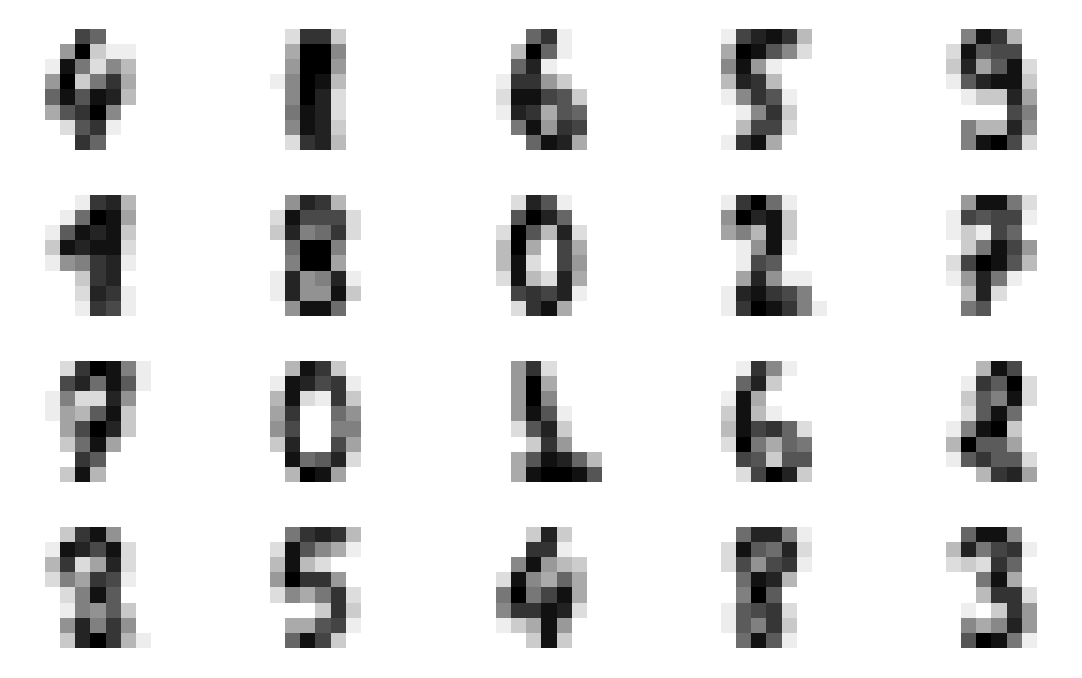

In [ ]:
from sklearn.cluster import KMeans

k = 20
kmeans = KMeans(init="random", n_clusters=k, n_init=20,
                random_state=2021, n_jobs = -1)
model = kmeans.fit(X_train)

# record centroid values
centroids = model.cluster_centers_

# reshape centroids into images
images = centroids.reshape(k, 8, 8)
#images *= 255
images = images.astype(np.uint8)

# create figure with subplots using matplotlib.pyplot
fs=(cm2inch(12,6))
fig, axs = plt.subplots(int(k/5), 5, figsize = fs, tight_layout = True, dpi = DPI)
plt.gray()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.tight_layout()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):    
    # add image to subplot    
    ax.matshow(255-images[i])
    ax.axis('off')

# display the figure
fig.show()
fig.savefig('6.3.png')

In [ ]:
#kmeans_labels = np.array([8,7,1,2,0,5,6,9,3,4])
kmeans_labels = np.array([4, 1, 6, 5, 9, 1, 8, 0, 2, 7, 7, 0, 1, 6, 2, 3, 5, 4, 8, 3])
"""kmeans_labels = np.array([8, 9, 8, 3, 4, 
                          3, 2, 7, 8, 9, 
                          6, 9, 2, 5, 8, 
                          1, 5, 6, 4, 1,
                          8, 0, 0, 7, 5
                          ])"""

#A questo punto utilizziamo il clustering per etichettare tutte le istanze
preds = kmeans.predict(X_train[n-k:])
label_preds = [kmeans_labels[i] for i in preds]

y_augmented = np.concatenate([y_train[:n-k], label_preds])

log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
log_reg.fit(X_train, y_augmented)
log_reg.score(X_test, y_test)

0.9111111111111111

In [ ]:
#Active learning
preds = kmeans.predict(X_train)
label_preds = [kmeans_labels[i] for i in preds]

####################
log_reg = LogisticRegression(solver = 'saga', max_iter = 2000)
log_reg.fit(X_train, label_preds)
print(log_reg.score(X_test, y_test))

####################
a = np.amax(log_reg.predict_proba(X_train), axis = 1)
c = a.argsort()[:n-k]

#Active learning injection
al_label_preds = []
for i in range(len(label_preds)):
  if i in c:     
    al_label_preds.append(y_train[i])    
  if not(i in c): 
    al_label_preds.append(label_preds[i])
    

new_log_reg = LogisticRegression(solver = 'saga', max_iter = 2000,  random_state = 2021)
new_log_reg.fit(X_train, al_label_preds)
print(new_log_reg.score(X_test, y_test)) 

0.9055555555555556
0.9111111111111111


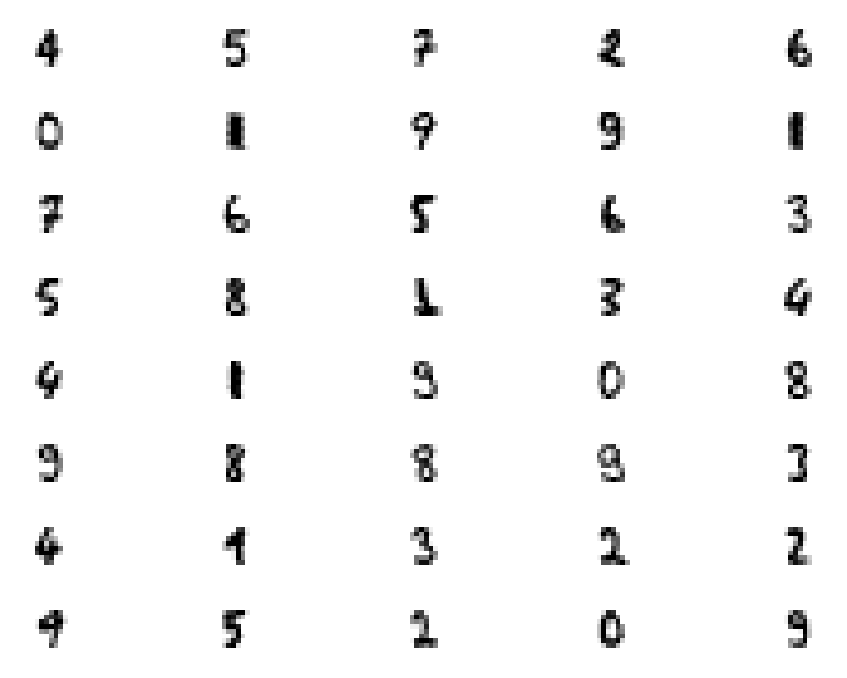

In [ ]:
from sklearn.cluster import KMeans

k = 40
kmeans = KMeans(init="random", n_clusters=k, n_init=20,
                random_state=2021, n_jobs = -1)
model = kmeans.fit_transform(X_train)

# record centroid values
rd_idx = np.argmin(model, axis = 0)
x_r = X_train[rd_idx]

# reshape centroids into images
images = x_r.reshape(len(rd_idx), 8, 8)
#images *= 255
images = images.astype(np.uint8)

# create figure with subplots using matplotlib.pyplot
fs=(cm2inch(12,6))
fig, axs = plt.subplots(int(k/5), 5, figsize = fs, tight_layout = True, dpi = DPI)
plt.gray()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.tight_layout()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):    
    # add image to subplot    
    ax.matshow(255-images[i])
    ax.axis('off')

# display the figure
fig.show()
fig.savefig('6.4.png')

In [ ]:
#Metodo dei centroidi

kmeans_labels = np.array([4, 5, 7, 2, 6, 
                          0, 1, 9, 9, 1, 
                          7, 6, 5, 6, 3,
                          5, 8, 1, 3, 4,
                          4, 1, 9, 0, 8,
                          9, 8, 8, 8, 3,
                          4, 1, 3, 2, 2,
                          9, 5, 2, 0, 9                  
                          ])


log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
log_reg.fit(x_r, kmeans_labels)
log_reg.score(X_test, y_test)

0.9

In [ ]:
#Analisi con 40 cluster

kmeans_labels = np.array([4, 5, 7, 2, 6, 
                          0, 1, 9, 9, 1, 
                          7, 6, 5, 6, 3,
                          5, 8, 1, 3, 4,
                          4, 1, 9, 0, 8,
                          9, 8, 8, 8, 3,
                          4, 1, 3, 2, 2,
                          9, 5, 2, 0, 9                  
                          ])

#A questo punto utilizziamo il clustering per etichettare tutte le istanze
preds = kmeans.predict(X_train)
label_preds = [kmeans_labels[i] for i in preds]


log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
log_reg.fit(X_train, label_preds)
log_reg.score(X_test, y_test)

0.9166666666666666

In [ ]:
new_log_reg2 = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
new_log_reg2.fit(X_train, y_train)
print(new_log_reg2.score(X_test, y_test)) 


0.9722222222222222


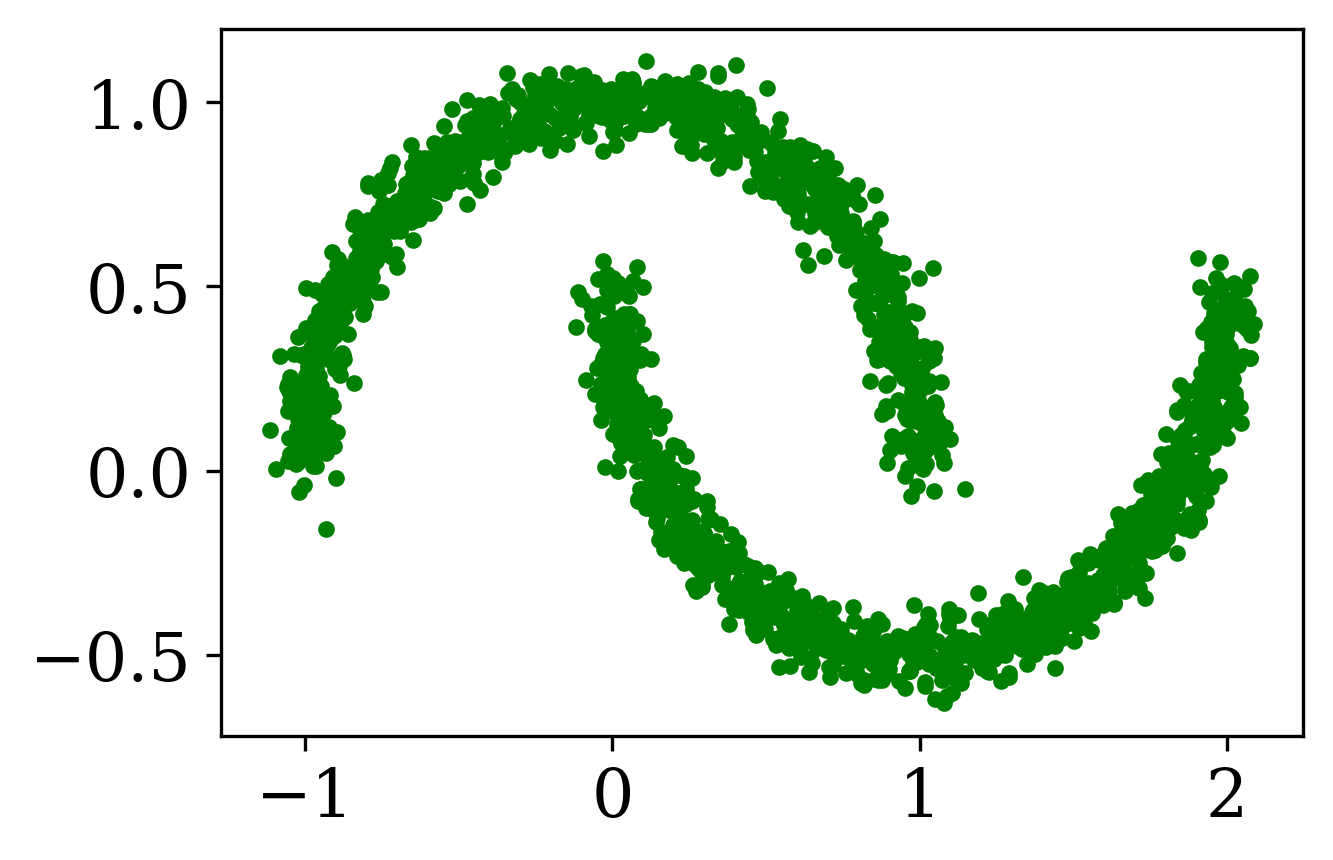

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

x,y = make_moons(n_samples=2000, noise=0.05, random_state=2021)

fs=(cm2inch(12,8))
fig, ax = plt.subplots(1, 1, figsize = fs, tight_layout = True, dpi = DPI)

ax.scatter(x[:,0],x[:,1],c="green",marker=".")
fig.show()
fig.savefig('6.5.png')

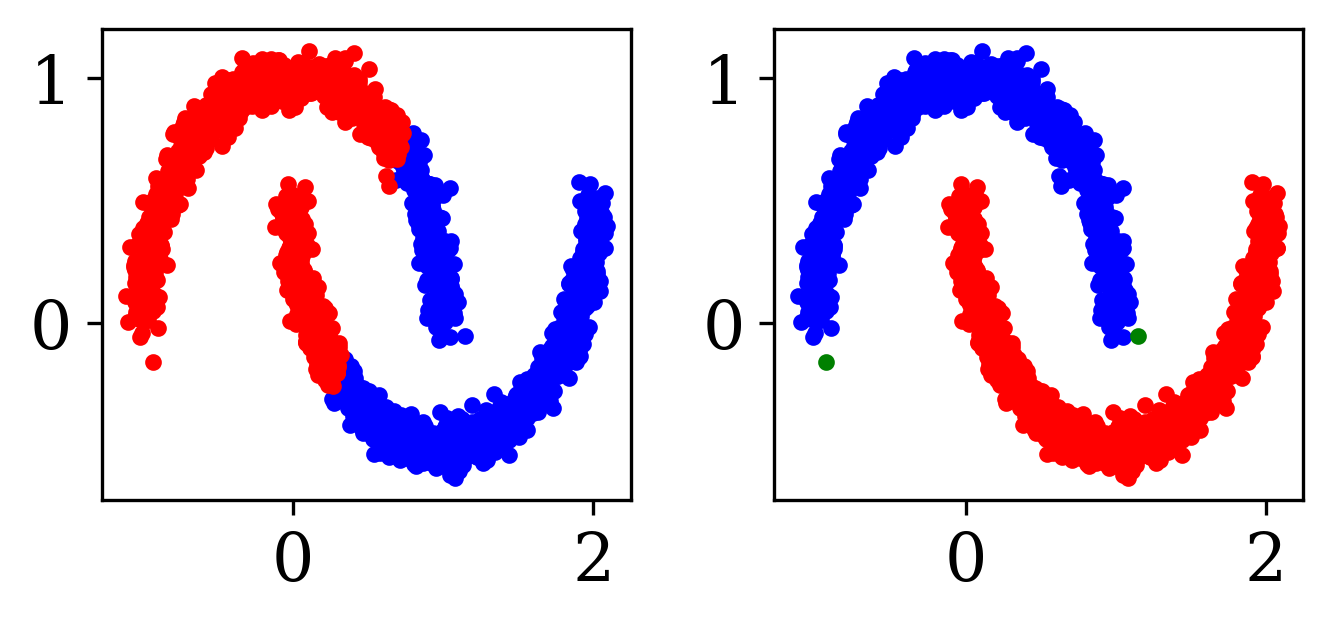

In [ ]:
fs=(cm2inch(12,6))
fig, ax = plt.subplots(1, 2, figsize = fs, tight_layout = True, dpi = DPI)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=2,init="k-means++",n_init=10,max_iter=300)
km_y = km.fit_predict(x)
ax[0].scatter(x[km_y==0,0],x[km_y==0,1],c="blue",marker=".",label="cluster 1")
ax[0].scatter(x[km_y==1,0],x[km_y==1,1],c="red",marker=".",label="cluster 2")
#plt.show()

minp = 4

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=minp)
nn = neigh.fit(x)
distances, indices = nn.kneighbors(x)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
##plt.plot(distances)
#plt.show()


from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.08, min_samples=minp, metric="euclidean")
dbscan_y = dbscan.fit_predict(x)
ax[1].scatter(x[dbscan_y==0,0],x[dbscan_y==0,1],c="blue",marker=".",label="cluster 1")
ax[1].scatter(x[dbscan_y==1,0],x[dbscan_y==1,1],c="red",marker=".",label="cluster 2")
ax[1].scatter(x[dbscan_y==-1,0],x[dbscan_y==-1,1],c="green",marker=".",label="Noise point")

fig.show()
fig.savefig('6.6.png')

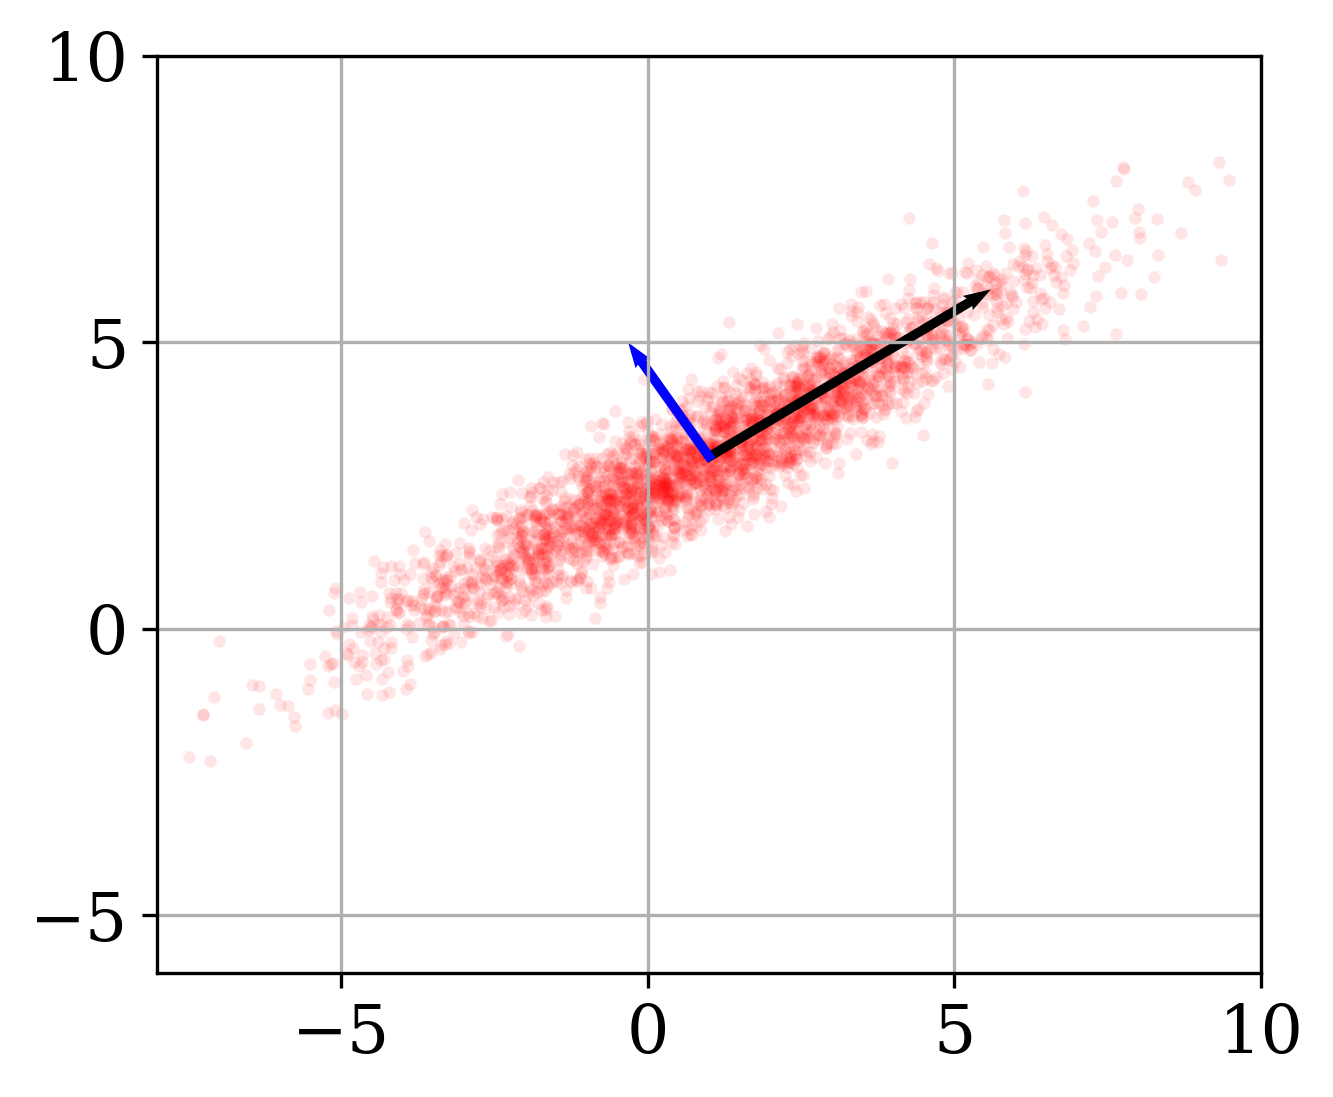

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

fs=(cm2inch(12,10))
fig, ax = plt.subplots(1, 1, figsize = fs, tight_layout = True, dpi = DPI)

ang = np.pi/6
mean = np.array([1, 3])
cov = np.array([[9, 0],
                [0, 0.25]])
rot = np.array([[np.cos(ang), -np.sin(ang)],
                [np.sin(ang), np.cos(ang)]])
cov = np.dot(rot, np.dot(cov, rot.T))

np.random.seed(seed=1)
data = np.random.multivariate_normal(mean, cov, size=(3000))
x = data[:, 0]
y = data[:, 1]

ax.grid(True)
ax.axis([-8, 10, -6, 10])
ax.scatter(x, y, c="r", marker = '.', alpha=0.1, lw=0)
ax.arrow(1, 3, 5*np.cos(ang), 5.5*np.sin(ang), width=0.02, color="k", lw=2,overhang=0.1)
ax.arrow(1, 3, -2.3*np.sin(ang), 2*np.cos(ang), width=0.02, color="b", lw=2,overhang=0.1)
fig.savefig('6.7.png')
fig.show()

(1437, 64)
(1437, 13)


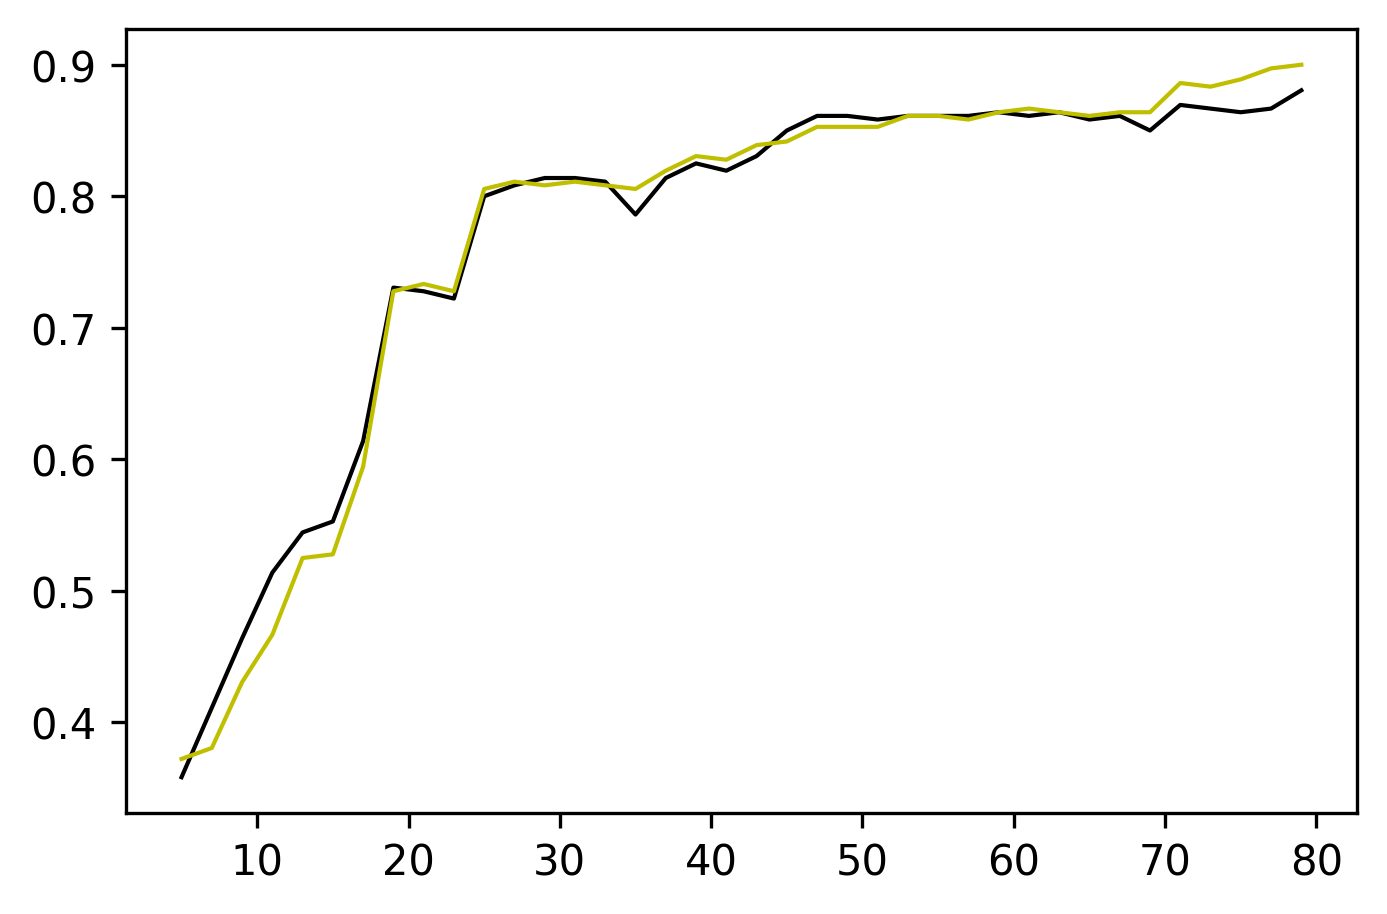

In [ ]:
#Scarichiamo il dataset Mnist attraverso il modulo di sklearn
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
#print(X.shape)
#print(y.shape)

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202)

from sklearn.decomposition import PCA

pca = PCA(n_components =  0.8)
model = pca.fit(X_train)
x_95 = model.transform(X_train)

print(X_train.shape)
print(x_95.shape)

from sklearn.linear_model import LogisticRegression


pca_fit = []
full_fit = []
for i in range(5,80,2):
  log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
  log_reg.fit(x_95[:i], y_train[:i])
  x_95_test = pca.transform(X_test)
  #print(log_reg.score(x_95_test, y_test))
  pca_fit.append(log_reg.score(x_95_test, y_test))

  log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
  log_reg.fit(X_train[:i], y_train[:i])
  #print(log_reg.score(X_test, y_test))
  full_fit.append(log_reg.score(X_test, y_test))

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.plot(range(5,80,2), pca_fit, "k-", linewidth=1)
ax.plot(range(5,80,2), full_fit, "y-", linewidth=1)

fig.show()
#fig.savefig('6.8.png')



In [ ]:
#Scarichiamo il dataset Mnist attraverso il modulo di sklearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", cache=True)

print(mnist.data.shape)
print(mnist.target.shape)

#Suddividiamo il dataset in variabili di input e di output
X = mnist.data[:1000]
y = mnist.target[:1000] 

(70000, 784)
(70000,)


(800, 784)
(800, 51)
50
75
100
125
150
175
200
225
250
275
300
325
350
375


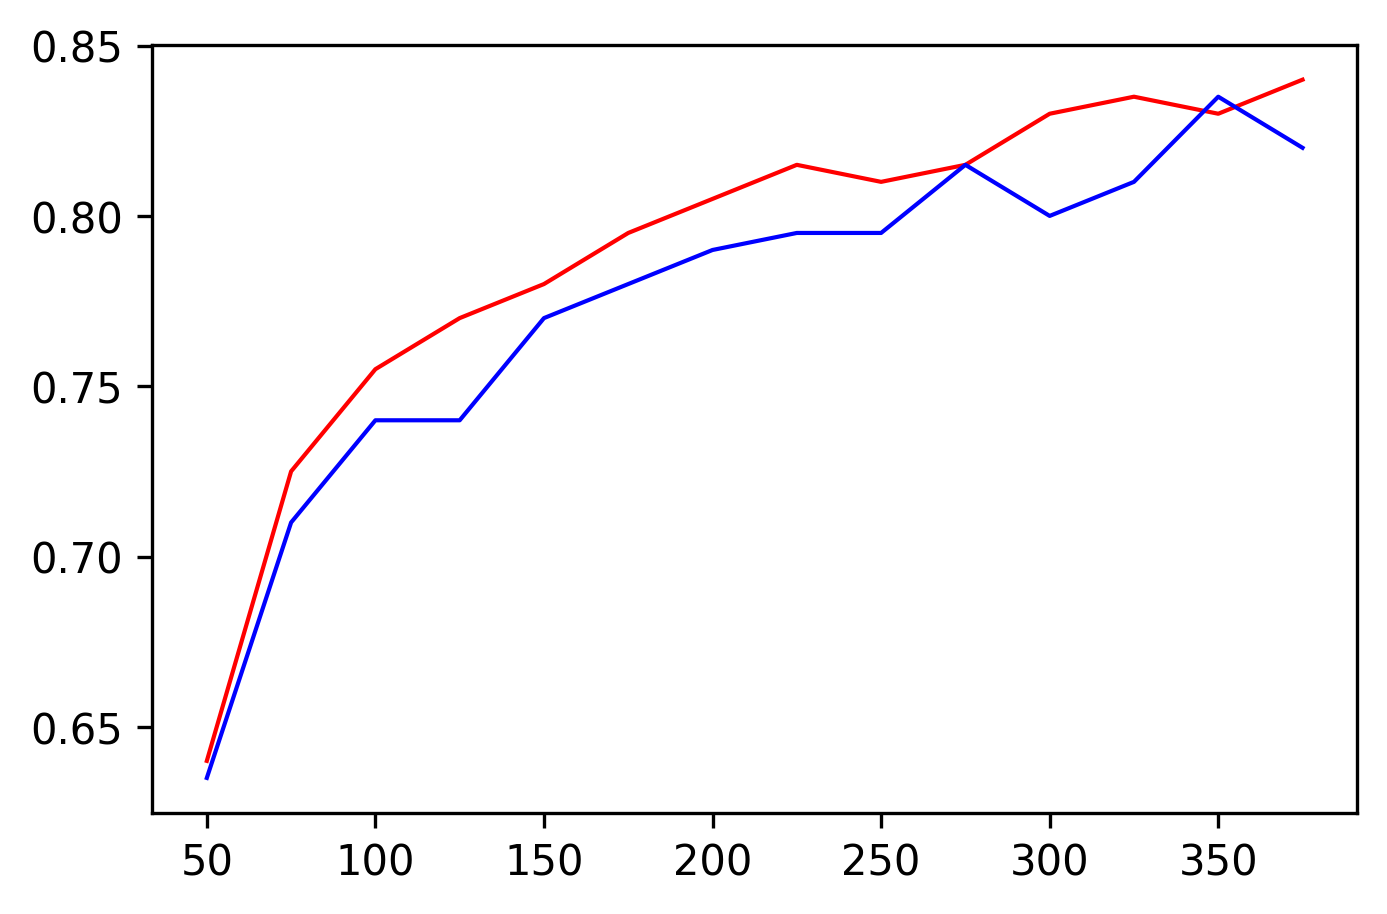

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202)

from sklearn.decomposition import PCA

pca = PCA(n_components =  0.85)
model = pca.fit(X_train)
x_85 = model.transform(X_train)

print(X_train.shape)
print(x_85.shape)

min = 50
max = 400
s = 25

pca_fit = []
full_fit = []
for i in range(min,max,s):
  print(i) 
  log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
  log_reg.fit(x_85[:i], y_train[:i])
  x_85_test = model.transform(X_test)
  #print(log_reg.score(x_95_test, y_test))
  pca_fit.append(log_reg.score(x_85_test, y_test))

  log_reg = LogisticRegression(solver = 'saga', max_iter = 2000, random_state = 2021)
  log_reg.fit(X_train[:i], y_train[:i])
  #print(log_reg.score(X_test, y_test))
  full_fit.append(log_reg.score(X_test, y_test))

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.plot(range(min,max,s), pca_fit, "r-", linewidth=1)
ax.plot(range(min,max,s), full_fit, "b-", linewidth=1)

fig.show()
fig.savefig('6.8.png')

(800, 784)
(800, 51)


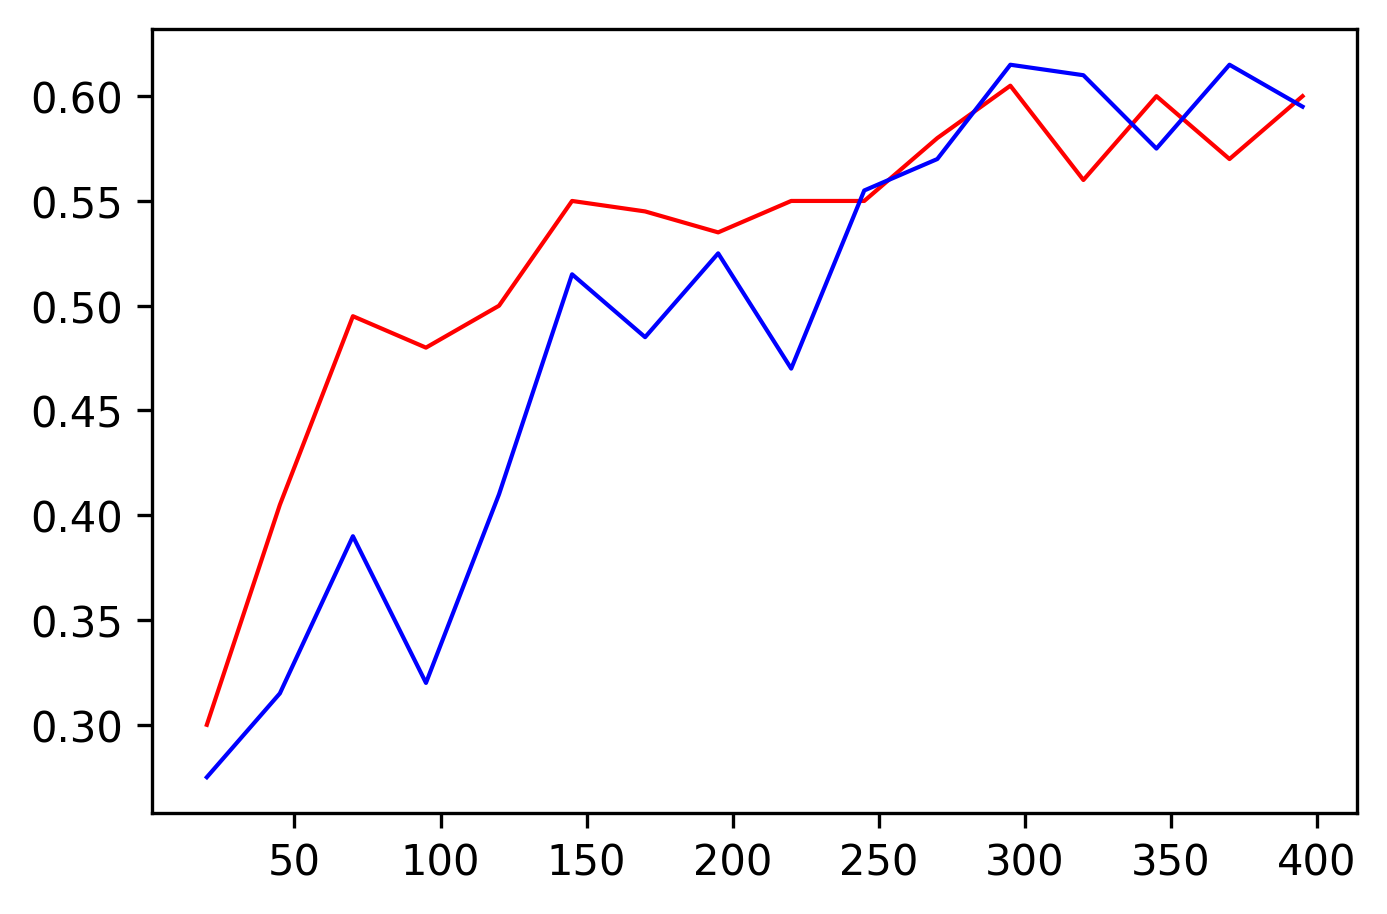

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202)

from sklearn.decomposition import PCA

pca = PCA(n_components =  0.85)
model = pca.fit(X_train)
x_95 = model.transform(X_train)

print(X_train.shape)
print(x_95.shape)

min = 20
max = 400
s = 25

pca_fit = []
full_fit = []
for i in range(min,max,s):  
  dtree = DecisionTreeClassifier(criterion='gini', max_depth=25)
  dtree.fit(x_95[:i], y_train[:i])
  x_95_test = pca.transform(X_test)
  #print(log_reg.score(x_95_test, y_test))
  pca_fit.append(dtree.score(x_95_test, y_test))

  dtree = DecisionTreeClassifier(criterion='gini', max_depth=25)
  dtree.fit(X_train[:i], y_train[:i])
  #print(log_reg.score(X_test, y_test))
  full_fit.append(dtree.score(X_test, y_test))

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.plot(range(min,max,s), pca_fit, "r-", linewidth=1)
ax.plot(range(min,max,s), full_fit, "b-", linewidth=1)

fig.show()
fig.savefig('6.9.png')

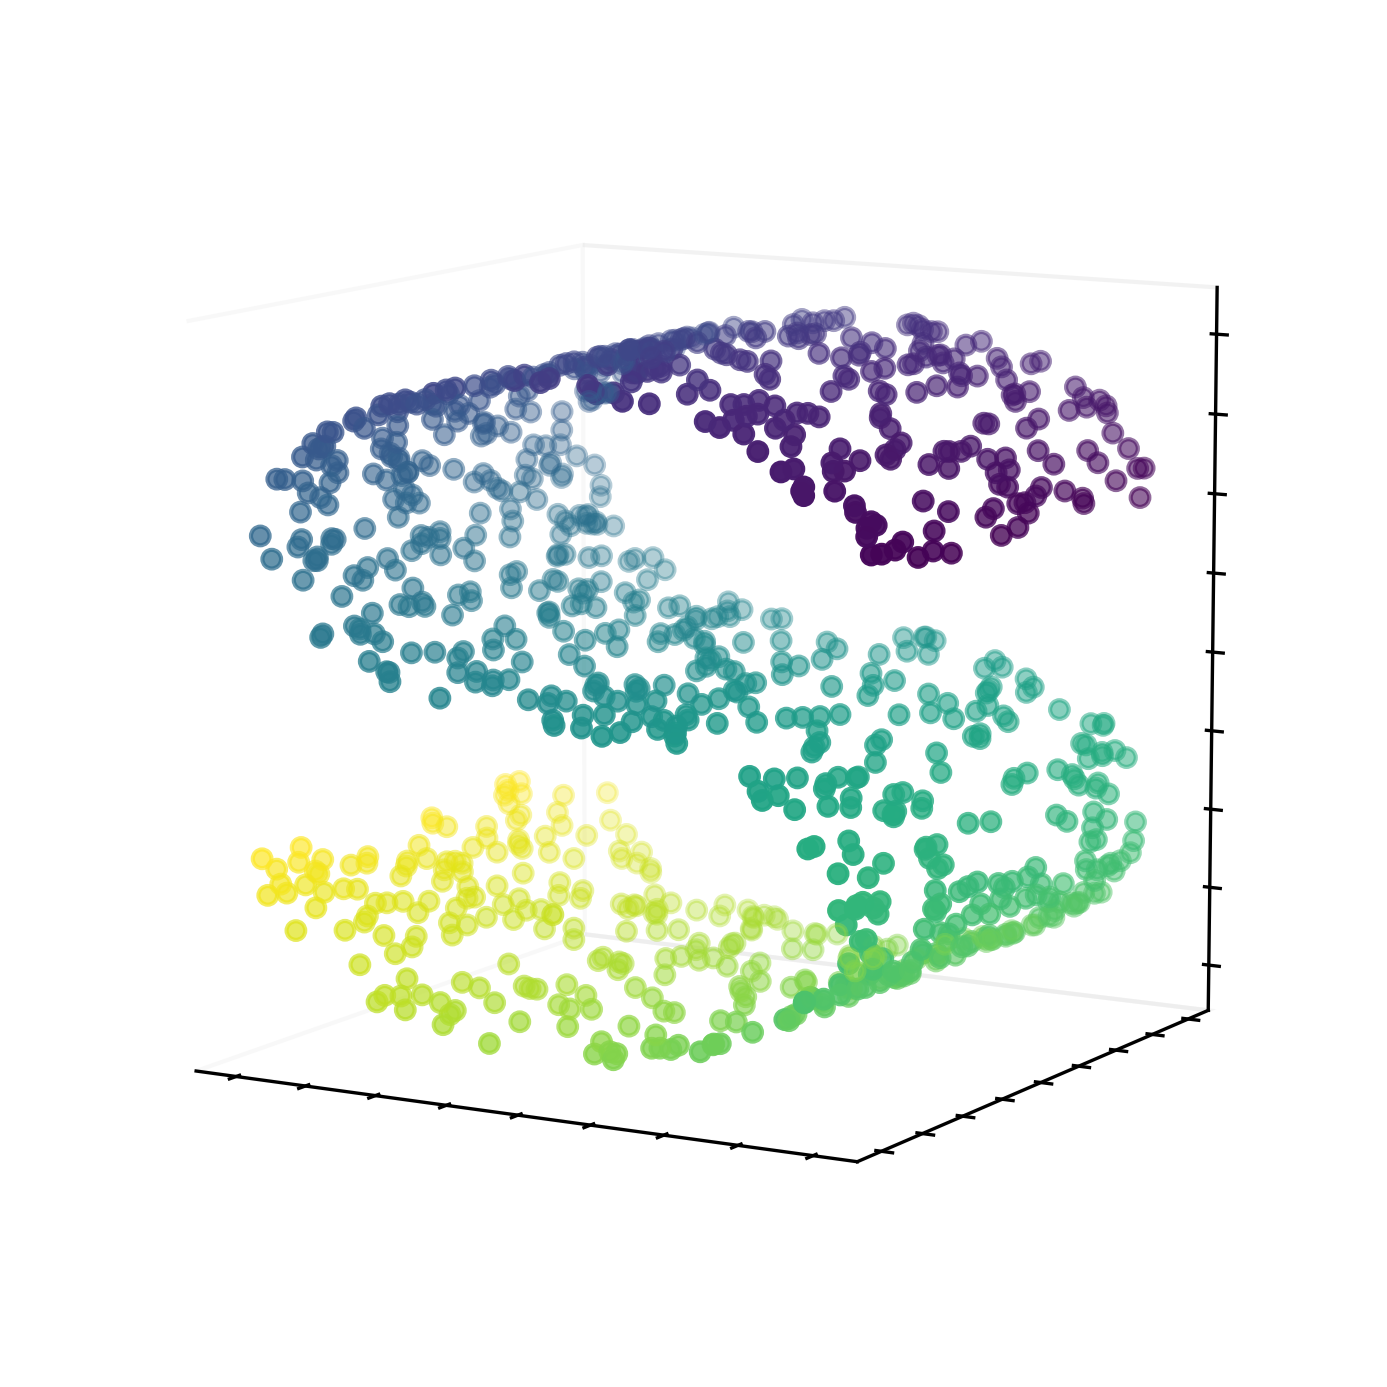

In [ ]:
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

Axes3D
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fs=(cm2inch(12,12))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=color)
ax.view_init(10, -60);
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.zaxis.set_major_formatter(NullFormatter())
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
#ax.xaxis.pane.set_edgecolor('w')
#ax.yaxis.pane.set_edgecolor('w')
#ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)
fig.savefig('6.10.png', bbox_inches = 'tight', pad_inches = 0.1)
fig.show()

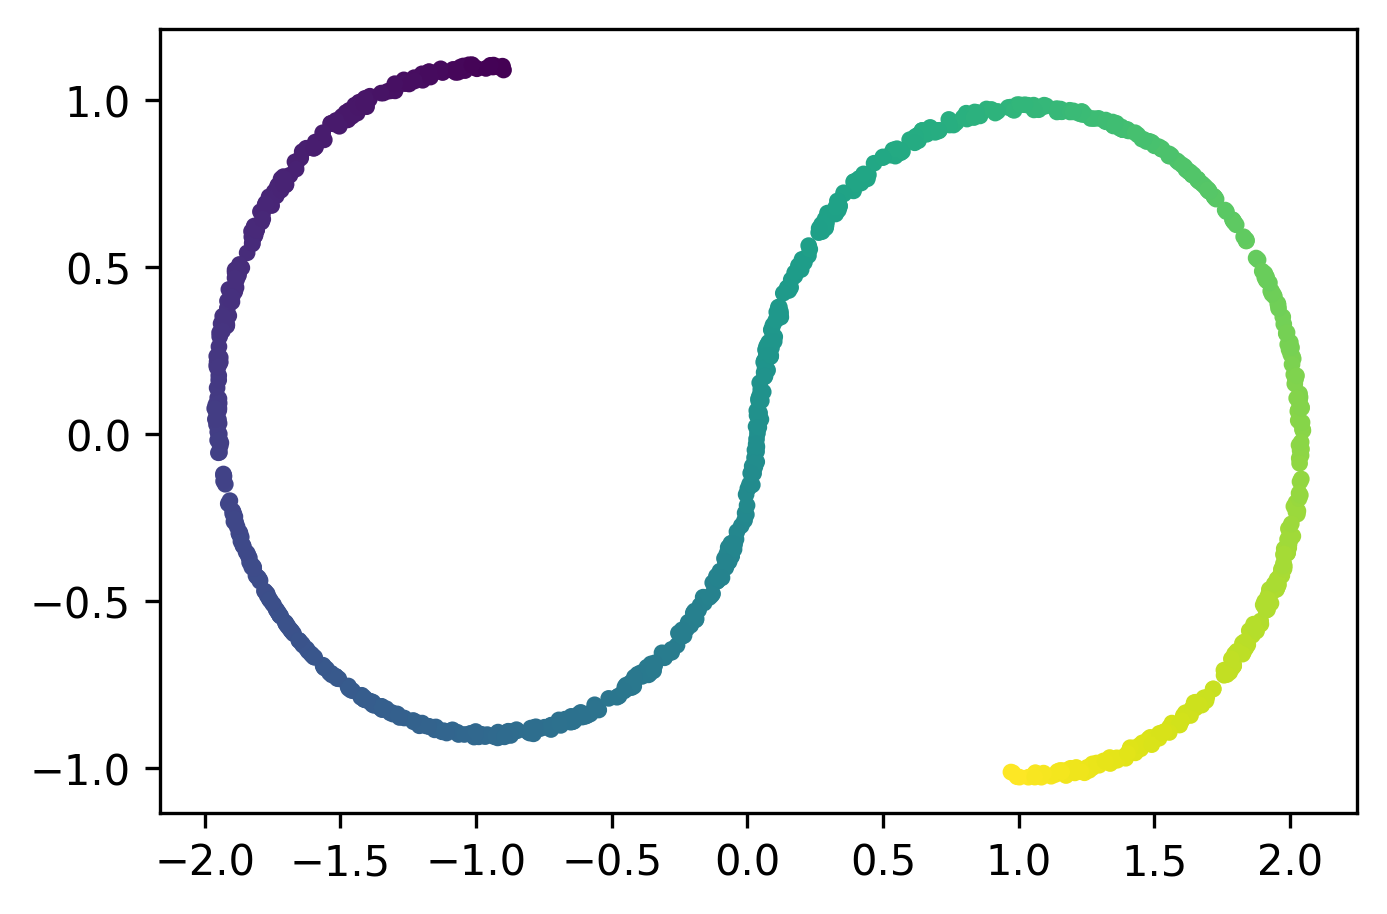

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components =  2)
X_t = pca.fit_transform(X)

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.scatter(X_t[:, 0], X_t[:, 1], marker = '.', c=color)
fig.savefig('6.11.png', bbox_inches = 'tight', pad_inches = 0.1)
fig.show()

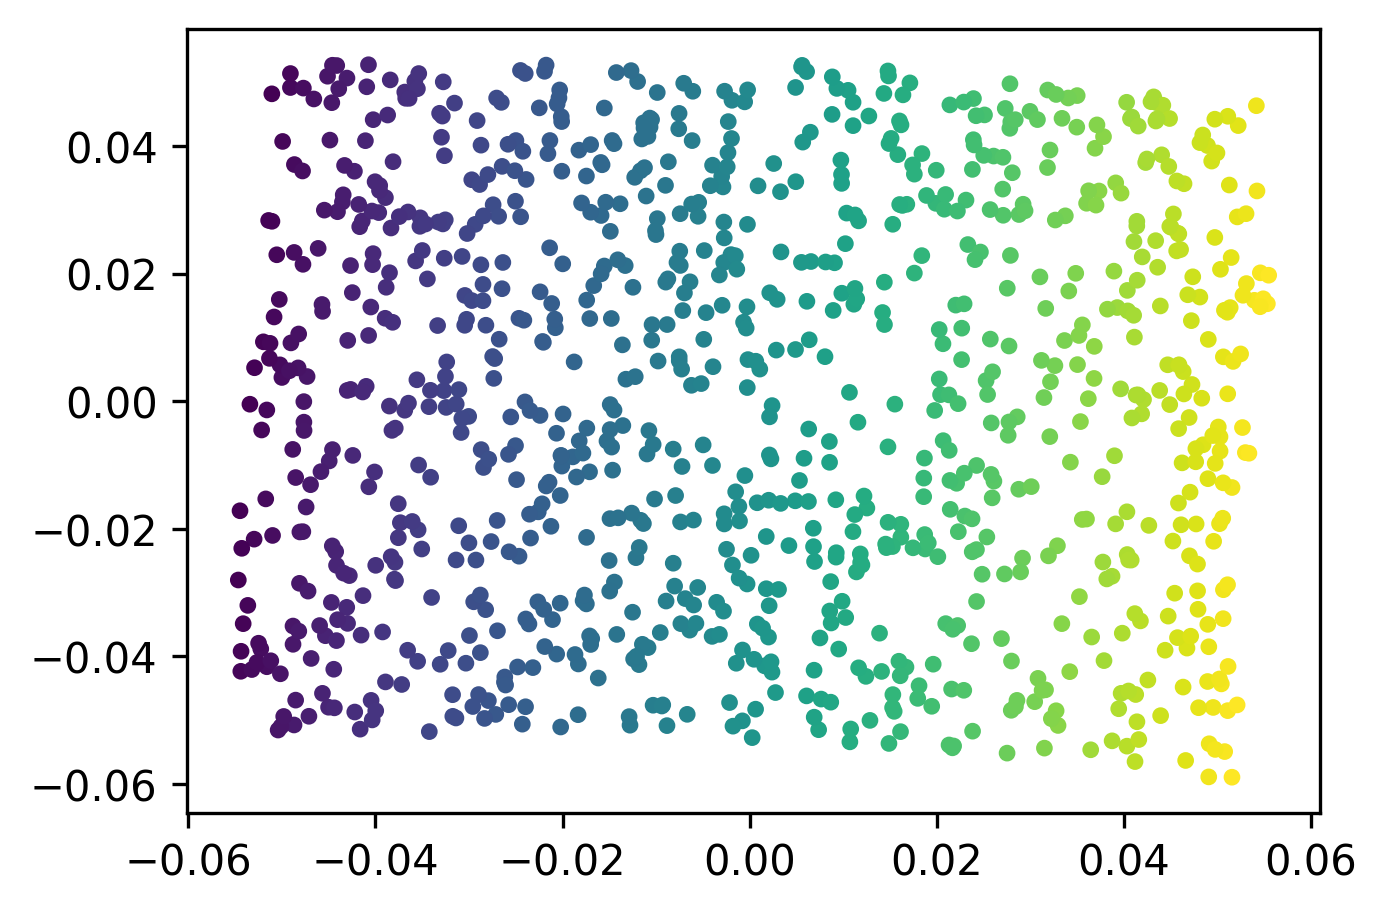

In [ ]:
from sklearn import manifold

lle = manifold.LocallyLinearEmbedding(method = 'modified', n_neighbors=12, n_components=2)
X_t = lle.fit_transform(X)

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.scatter(X_t[:, 0], X_t[:, 1], marker = '.', c=color)
fig.savefig('6.11.png', bbox_inches = 'tight', pad_inches = 0.1)
fig.show()

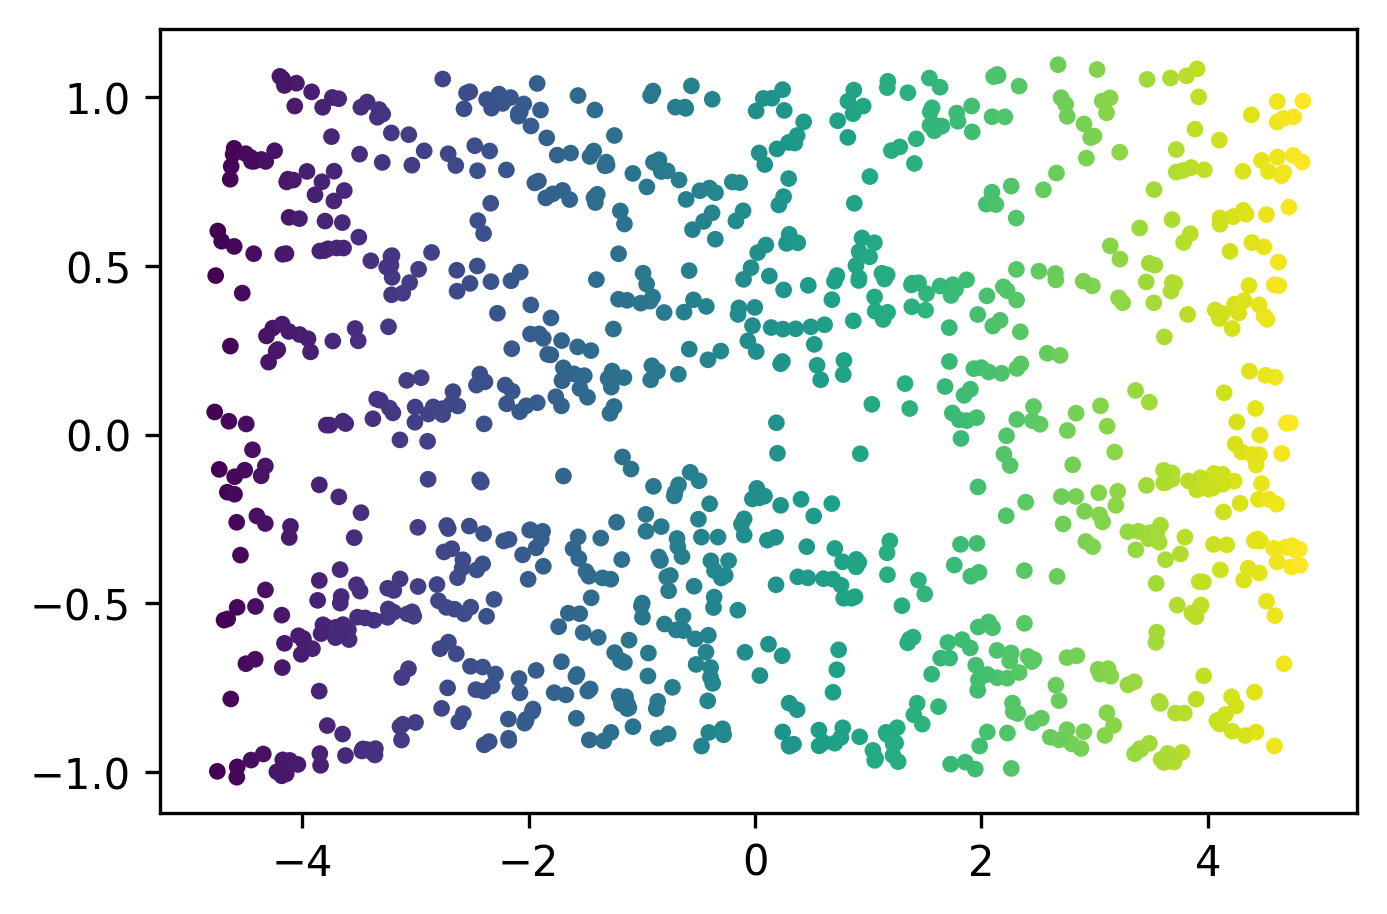

In [ ]:
from sklearn import manifold

isomap = manifold.Isomap(n_neighbors=12, n_components=2)
X_t = isomap.fit_transform(X)

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.scatter(X_t[:, 0], X_t[:, 1], marker = '.', c=color)
fig.savefig('6.13.png', bbox_inches = 'tight', pad_inches = 0.1)
fig.show()

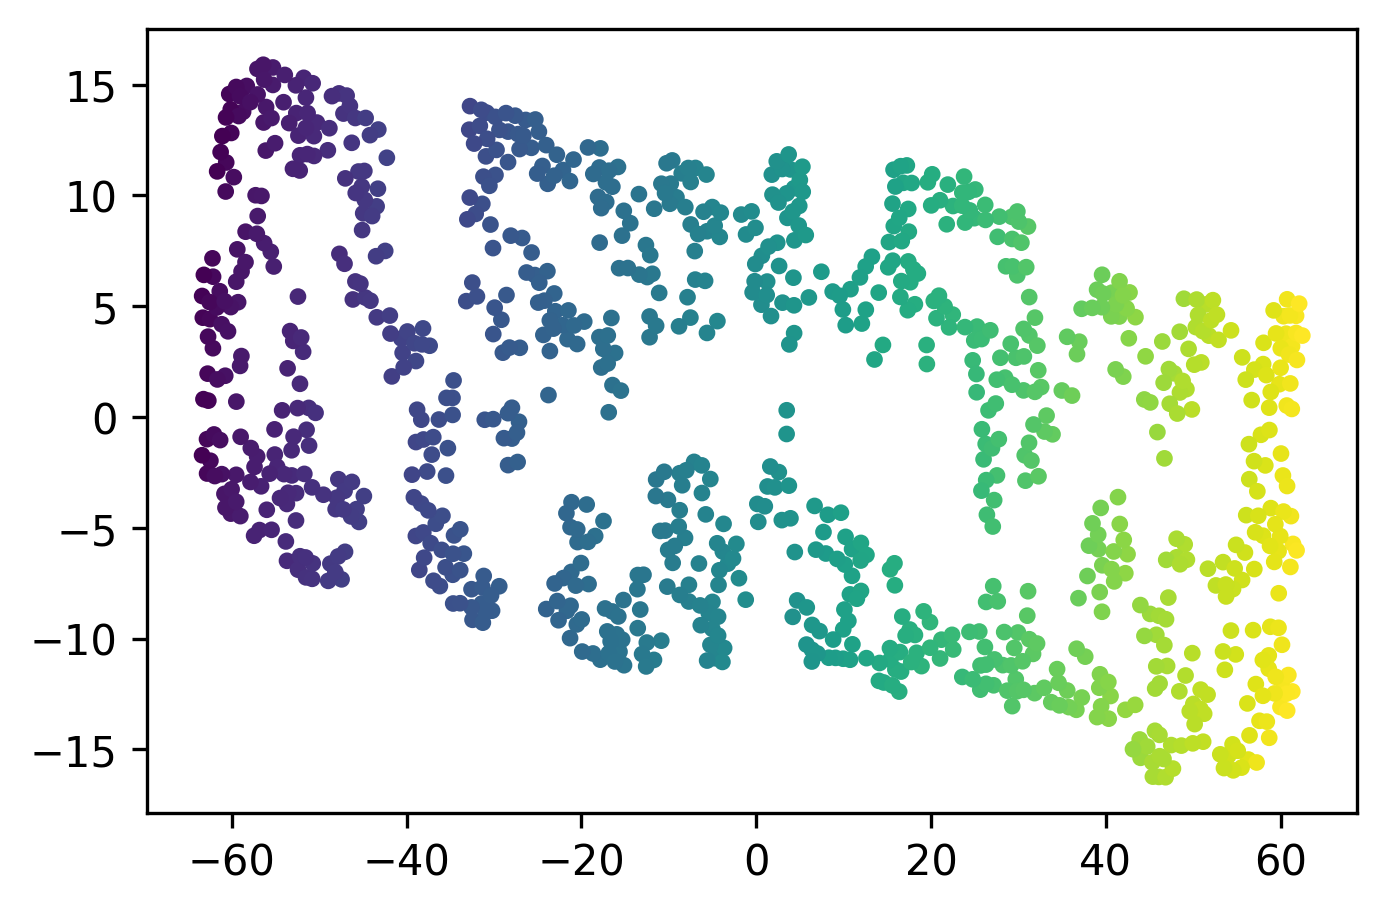

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, init='pca',
                                 random_state=0)
X_t = tsne.fit_transform(X)

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.scatter(X_t[:, 0], X_t[:, 1], marker = '.', c=color)
fig.savefig('6.14.png', bbox_inches = 'tight', pad_inches = 0.1)
fig.show()

In [ ]:
#Scarichiamo il dataset Mnist attraverso il modulo di sklearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", cache=True)

print(mnist.data.shape)
print(mnist.target.shape)

#Suddividiamo il dataset in variabili di input e di output
X = mnist.data[:10000]
y = mnist.target[:10000] 

(70000, 784)
(70000,)


(8000, 784)
(8000, 50)
0.3885
0.3335
0.546
0.4775
0.5525
0.4865
0.623
0.5265
0.6405
0.567
0.6985
0.577
0.713
0.593
0.705
0.605
0.733
0.635
0.713
0.6335
0.722
0.637
0.733
0.6485
0.7425
0.6745
0.738
0.648
0.7595
0.6665
0.7705
0.6725
0.7555
0.661
0.779
0.6785
0.7605
0.6845
0.758
0.6825
0.7725
0.697
0.77
0.685
0.7805
0.698
0.774
0.7055
0.7815
0.7175
0.7835
0.717
0.797
0.717
0.791
0.6955
0.8045
0.7195
0.79
0.7105
0.7925
0.7165
0.789
0.7095
0.8035
0.7095
0.8035
0.7125
0.797
0.704
0.7925
0.715
0.793
0.7125
0.798
0.7145
0.7965
0.7105
0.7935
0.7215
0.8095
0.7105
0.8035
0.713
0.801
0.7235
0.814
0.709
0.8105
0.7255
0.808
0.7255
0.8155
0.723
0.8165
0.7395
0.82
0.732
0.8375
0.734
0.8225
0.749
0.825
0.741
0.821
0.738
0.8345
0.741
0.833
0.741
0.823
0.74
0.822
0.74
0.8135
0.745
0.8185
0.7445
0.819
0.742
0.817
0.7515
0.8295
0.7525
0.823
0.732
0.8255
0.7465
0.821
0.7545
0.8265
0.7465
0.835
0.755
0.8305
0.7535
0.826
0.7645
0.829
0.7545
0.831
0.7515
0.83
0.767
0.8325
0.771
0.8355
0.7655
0.8385
0.7825
0.83

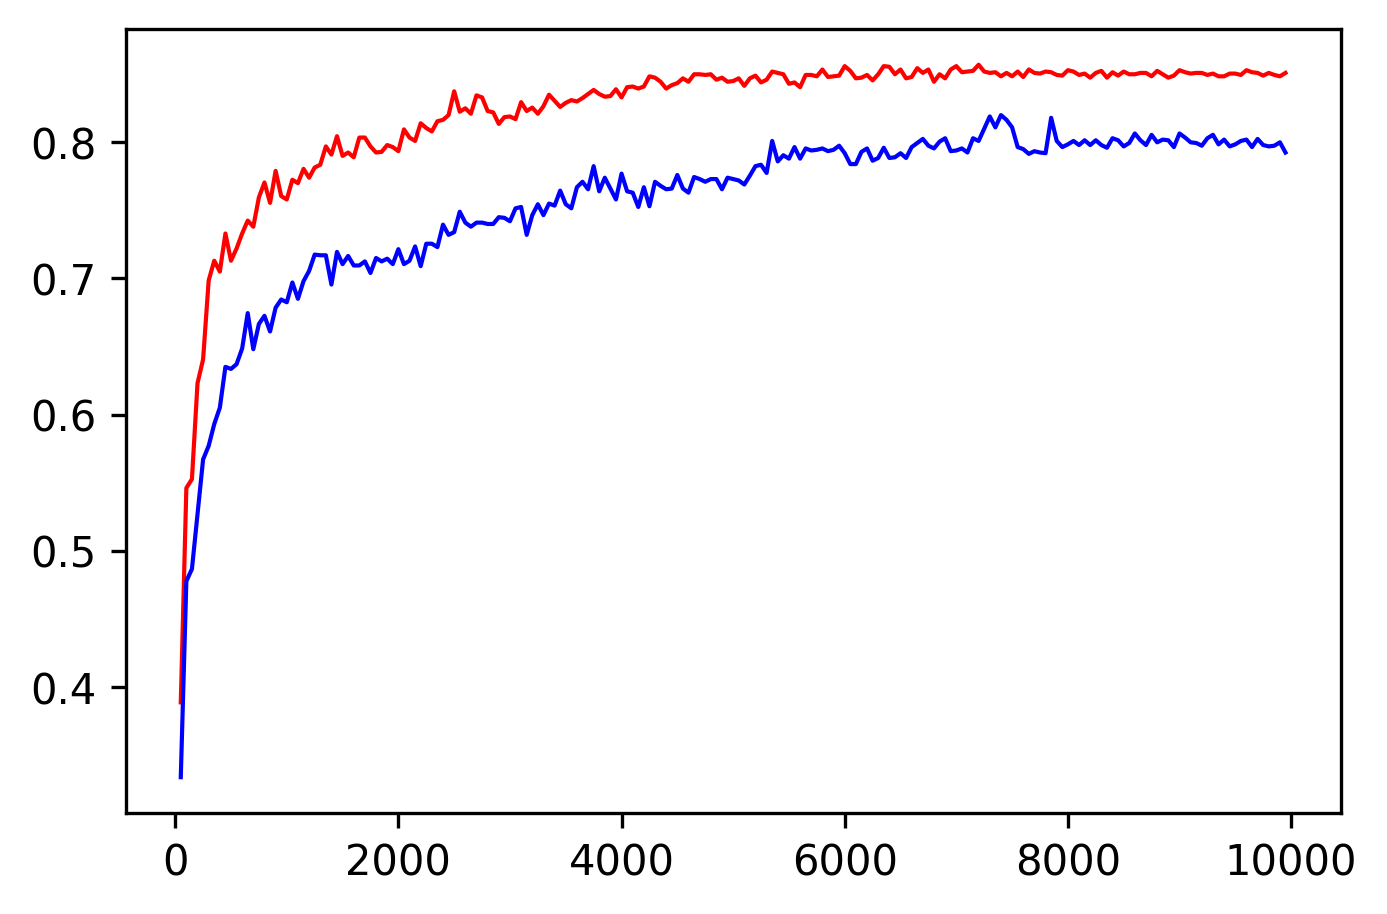

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import manifold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 202)

from sklearn.decomposition import PCA

isomap = manifold.Isomap(n_neighbors=12, n_components=50)
x_95 = isomap.fit_transform(X_train)
x_95_test = isomap.transform(X_test)

print(X_train.shape)
print(x_95.shape)

In [ ]:
min = 50
max = 10000
s = 50

from sklearn.preprocessing import StandardScaler

pca_fit = []
full_fit = []
for i in range(min,max,s):  
  dtree = DecisionTreeClassifier(criterion='gini', max_depth=10)
  dtree.fit(x_95[:i], y_train[:i])  
  print(dtree.score(x_95_test, y_test))
  pca_fit.append(dtree.score(x_95_test, y_test))

  dtree = DecisionTreeClassifier(criterion='gini', max_depth=10)
  dtree.fit(X_train[:i], y_train[:i])
  print(dtree.score(X_test, y_test))
  full_fit.append(dtree.score(X_test, y_test))

fs=(cm2inch(12,8))
fig, ax=plt.subplots(figsize=fs, dpi=DPI, nrows=1, ncols=1, tight_layout=True)
ax.plot(range(min,max,s), pca_fit, "r-", linewidth=1)
ax.plot(range(min,max,s), full_fit, "b-", linewidth=1)

fig.show()
fig.savefig('6.15.png')